# Hyperparameters and validation sets

## Prerequisites
- [Bias, variance and generalisation](https://theaicore.com/app/training/bias-var)
- [Tensorboard]()
- [Gradient based optimisation](https://theaicore.com/app/training/grad-optim)

## Create a function for us to model

Start by running the code cell below. It will create a random polynomial function which we will try to model, and also sample some data from it which will be examples in our dataset which we can train and test our model on.

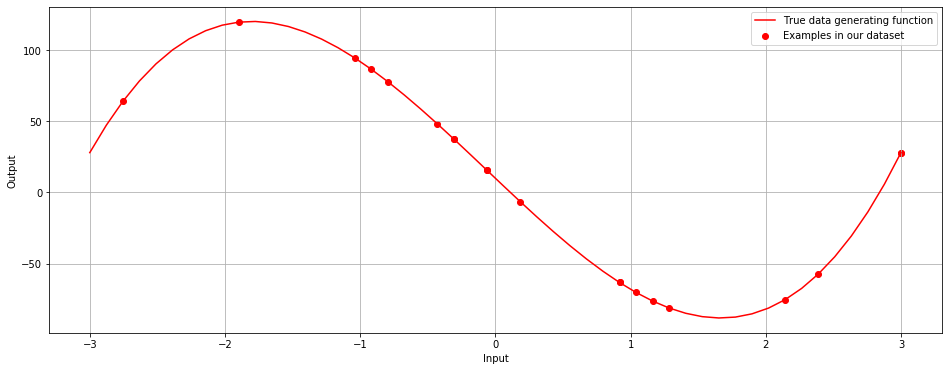

In [1]:
import torch
from torchvision import datasets, transforms
import numpy
from numpy.polynomial import Polynomial
import matplotlib.pyplot as plt
import numpy as np

_range = 3
all_possible_inputs = np.linspace(-_range, _range, 50) # create a range of inputs 
m = 20 # how many examples do we want?
dataset = np.random.choice(all_possible_inputs, size=(m,)) # here we randomly sample some inputs from the true data
true_coeffs = (10, -90, 2, 10) # coefficients of our data generating function
Y_fn = np.polynomial.polynomial.Polynomial(true_coeffs) # create a polynomial data generating function with these coefficients
Y = Y_fn(dataset) # evaluate our data generating function on these inputs

fig = plt.figure(figsize=(16, 6))
plt.scatter(dataset, Y, c='r', label='Examples in our dataset')
plt.plot(all_possible_inputs, Y_fn(all_possible_inputs), c='r', label='True data generating function')
plt.xlabel('Input')
plt.ylabel('Output')
plt.grid()
plt.legend()
plt.show()

## Let's split our dataset into training and testing sets 

PyTorch has a utility method `torch.utils.data.random_split()` that makes it easy to randomly split a dataset. 
The first argument is the dataset that you want to split.
The second argument it a list of the sizes of each output dataset.
The sum of the sizes in this list must be equal to the length of the dataset that you are splitting.
You can split the input dataset into more than just 2 by providing more than 2 sizes in the second argument.
Check out the [docs](https://pytorch.org/docs/stable/data.html#torch.utils.data.random_split) here.

We will fully introduce the core of PyTorch in the next [notebook](https://theaicore.com/app/training/pytorch)

len total dataset: 20
len train_set: 10
len test_set: 10


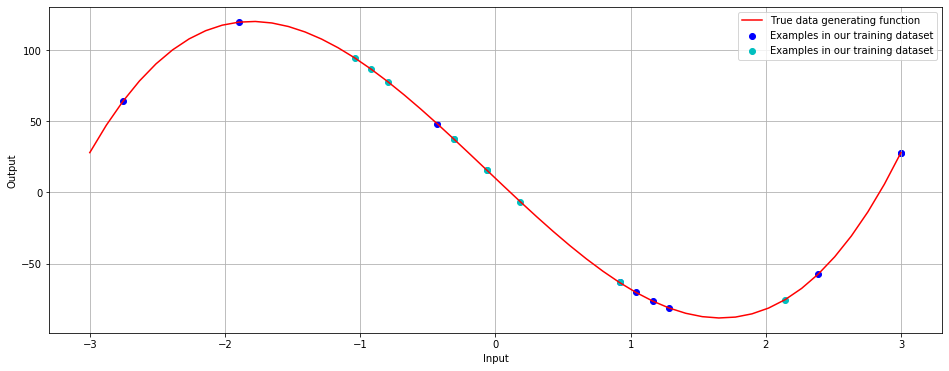

In [2]:
print('len total dataset:', len(dataset))

train_data, test_data,  = torch.utils.data.random_split(dataset, [10, 10]) # randomly split data into train and validation sets

print('len train_set:', len(train_data))
print('len test_set:', len(test_data))

plt.figure(figsize=(16, 6))
plt.scatter(train_data, Y_fn(train_data), c='b', label='Examples in our training dataset')
plt.scatter(test_data, Y_fn(test_data), c='c', label='Examples in our training dataset')
plt.plot(all_possible_inputs, Y_fn(all_possible_inputs), c='r', label='True data generating function')
plt.xlabel('Input')
plt.ylabel('Output')
plt.grid()
plt.legend()
plt.show()

## Let's train a polynomial model and test it's performance

We've done this many times by now. Run the cell below.

In [3]:
class MultiVariableLinearHypothesis:
    def __init__(self, n_features):
        self.n_features = n_features
        self.b = np.random.randn()
        self.w = np.random.randn(n_features)
    def __call__(self, X): #input is of shape (n_datapoints, n_vars)
        y_hat = np.matmul(X, self.w) + self.b
        return y_hat #output is of shape (n_datapoints, 1)
    def update_params(self, new_w, new_b):
        self.w = new_w
        self.b = new_b
    def calc_deriv(self, X, y_hat, labels):
        diffs = y_hat - labels
        dLdw = 2 * np.array([np.sum(diffs * X[:, i]) / m for i in range(self.n_features)])                          
        dLdb = 2 * np.sum(diffs)/m
        return dLdw, dLdb
            
def train(num_epochs, X, Y, H):
    for e in range(num_epochs): # for this many complete runs through the dataset
        y_hat = H(X) # make predictions
        dLdw, dLdb = H.calc_deriv(X, y_hat, Y) # calculate gradient of current loss with respect to model parameters
        new_w = H.w - learning_rate * dLdw # compute new model weight using gradient descent update rule
        new_b = H.b - learning_rate * dLdb # compute new model bias using gradient descent update rule
        H.update_params(new_w, new_b) # update model weight and bias
        
def test(X, Y, H):
    y_hat = H(X) # make predictions
    loss = np.sum((y_hat - Y)**2) / len(Y) # calculte mean squared error
    return loss
                           
def create_polynomial_inputs(X, order=3):
    new_dataset = np.array([X, *[np.power(X, i) for i in range(2, order + 1)]]).T
    return new_dataset # new_dataset should be shape [m, order]

num_epochs = 100000
learning_rate = 0.0001
highest_order_power = 1

X = create_polynomial_inputs(train_data, highest_order_power) # create polynomial inputs
Y = Y_fn(train_data)
H = MultiVariableLinearHypothesis(n_features=highest_order_power) # initialise our model
    
train(num_epochs, X, Y, H) # train model and plot cost curve
loss = test(X, Y, H)
print('LOSS:', loss)

fig = plt.figure((16, 6))
plt.scatter(train_data, Y_fn(train_data), c='r', label='Label')
plt.plot(all_possible_inputs, Y_fn(all_possible_inputs), c='r')
plt.scatter(train_data, H(X), c='b', label='Prediction', marker='x')
plt.plot(all_possible_inputs, H(create_polynomial_inputs(all_possible_inputs, highest_order_power)), c='b')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

LOSS: 3334.9468916416254


TypeError: int() argument must be a string, a bytes-like object or a number, not 'tuple'

Run `tensorboard --logdir=runs` in your terminal to start tensorboard. Then run the cell below to get some data, create training and test data loaders, train a neural network on the test set and plot its loss on to tensorboard (see this by visiting tensorboard at [localhost:6006](http://localhost:6006)).

Within Tensorboard you should be able to see the nice looking loss curve (once you've started it from your terminal).

## Hyperparameters

You've probably already asked questions along the lines of "What batch size should I use?", "What learning rate should I use?", "What polynomial terms should my model include?".

The batch size, learning rate and model architecture are all examples of **hyperparameters**. They are not optimised by the learning algorithm itself.

Most commonly, a parameter is chosen to be a hyperparameter becuase optimising this parameter on the training set is not appropriate. For example, the number of polynomial terms in a model is a hyperparameter. This is because a model with more polynomial terms means a model with greater capacity. So if optimised directly, the optimal value is as large as possible. This would lead to the model overfitting. As such, any parameters that control the capacity of a model should be hyperparameters.

Other times, a parameter may be chosen to be a hyperparameter if is challenging to optimise. For example, the batch size. The batch size is challenging to optimise because you will need to fully train and test many different models to compare how changing it affects the final loss on the test set.

In [4]:
# HERE ARE SOME HYPERPARAMETERS THAT WE WILL OPTIMISE
learning_rates = [0.0015, 0.001, 0.002]#, 0.00001]
highest_order_powers = [1, 2, 3]#, 4, 5]

losses = np.zeros((len(learning_rates), len(highest_order_powers)))
for pow_idx, highest_order_power in enumerate(highest_order_powers):
    X = create_polynomial_inputs(train_data, highest_order_power) # create polynomial inputs
    Y = Y_fn(train_data)
    H = MultiVariableLinearHypothesis(n_features=highest_order_power) # initialise our model
    for lr_idx, learning_rate in enumerate(learning_rates):
        print()
        train(num_epochs, X, Y, H)
        loss = test(X, Y, H)
        print(f'Learning rate: {learning_rate}\tHighest order power: {highest_order_power}\tLoss: {loss}')
        losses[lr_idx][pow_idx] = loss
             
            
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm

norm = plt.Normalize(losses.min(), losses.max())
colors = cm.viridis(norm(losses))
rcount, ccount, _ = colors.shape

%matplotlib

fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111, projection='3d')
lrs, pows = np.meshgrid(highest_order_powers, learning_rates)
print(lrs.shape)
print(pows.shape)
print(losses.shape)
s = ax.plot_surface(pows, lrs, losses, cmap=cm.coolwarm, rcount=rcount, ccount=ccount, facecolors=colors, shade=False)
ax.set_xlabel('Learning rate')
ax.set_ylabel('Highest order power')
ax.set_zlabel('Loss')
plt.show()


Learning rate: 0.0015	Highest order power: 1	Loss: 3334.9468806080813

Learning rate: 0.001	Highest order power: 1	Loss: 3334.9468806080813

Learning rate: 0.002	Highest order power: 1	Loss: 3334.9468806080813

Learning rate: 0.0015	Highest order power: 2	Loss: 1818.753436351717

Learning rate: 0.001	Highest order power: 2	Loss: 1818.753436351717

Learning rate: 0.002	Highest order power: 2	Loss: 1818.753436351717

Learning rate: 0.0015	Highest order power: 3	Loss: 7.143434127960542e-23

Learning rate: 0.001	Highest order power: 3	Loss: 7.143434127960542e-23

Learning rate: 0.002	Highest order power: 3	Loss: 3.988614022735982e-23
Using matplotlib backend: GTK3Agg
(3, 3)
(3, 3)
(3, 3)


## Why should we not tune our hyperparameters based on our model's score on the test set?

Previously we have split our data into train and test sets. The test set is for estimating how well our model  will generalise to perform well on unseen examples. It is important that we do not use the test set to make any decisions about the model. If we do, our model would be overfit to the test set because we are both training and testing our hyperparameters on the test data.

You may find that a certain set of hyperparameters perform well on the test set, but then fail to perform as well in the wild when the model is being evaluated on other unseen examples because the hyperparameters that you selected were optimised for *this* test data. 

## What else can we test them on? 

Just like we previously split our data into train and test sets. We can split our train set into a final train set and **validation set**. 

We can then use this split-off validation dataset to validate that the current hyperparameters will make our model to perform well on unseen data - both the validation set and the test set are unseen.


In [7]:

train_data, val_data,  = torch.utils.data.random_split(train_data, [10, 5]) # randomly split data into train and validation sets

print('len train_set:', len(train_data))
print('len val_set:', len(val_data))

len total dataset: 15
len train_set: 10
len val_set: 5


NameError: name 'test_data' is not defined

In [ ]:
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F

# MAKE DATALOADERS
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

# CREATE NEURAL NETWORK MODEL TEMPLATE
class NN(torch.nn.Module): # create a neural network class
    def __init__(self): # initialiser
        super().__init__() # initialise the parent class
        self.layer1 = torch.nn.Linear(784, 1024) # create our first linear layer
        self.layer2 = torch.nn.Linear(1024, 256) # create our second linear layer
        self.layer3 = torch.nn.Linear(256, 10) # create our third linear layer
        
    def forward(self, x): # define the forward pass
        x = x.view(-1, 784) # flatten out our image features into vectors
        x = self.layer1(x) # pass through the first linear layer
        x = F.relu(x) # apply activation function
        x = self.layer2(x) # pass through the second linear layer
        x = F.relu(x) # apply activation function
        x = self.layer3(x) # pass through the third linear layer
        x = F.softmax(x, dim=0) # apply activation function
        return x # return output
    
my_nn = NN() # initialise our model

# CREATE OUR OPTIMISER
optimiser = torch.optim.Adam(              # what optimiser should we use?
    my_nn.parameters(),          # what should it optimise?
)
        
# CREATE OUR CRITERION
criterion = torch.nn.CrossEntropyLoss() # returns a callable object that compares our predictions to our labels and returns our loss

# SET UP TRAINING VISUALISATION
writer = SummaryWriter() # we will use this to show our models performance on a graph
    
# TRAINING LOOP
def train_epoch(model):
    for idx, minibatch in enumerate(train_loader): # for each mini-batch sampled from the training dataloader
        inputs, labels = minibatch # unpack the inputs and labels from the minibatch
        prediction = model(inputs) # pass the data forward through the model
        loss = criterion(prediction, labels) # compute the loss
        optimiser.zero_grad() # reset the gradients attribute of each of the model's params to zero
        loss.backward() # backward pass to compute and set all of the model param's gradients
        optimiser.step() # update the model's parameters
        writer.add_scalar('Loss/Train', loss, epoch*len(train_loader) + idx) # write loss to a graph
    print('Epoch:', epoch, '\tLoss:', loss.data)
    
    

train_epoch(my_nn, 1) # train for 10 epochs

## Let's implement a grid search to optimise our hyperparameters